In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import pmdarima as pm
from mlforecast import MLForecast
from mlforecast.target_transforms import BaseTargetTransform
from neuralforecast import NeuralForecast

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from src.data.loaders import CommodityLoader
from src.models.ensemble.dynamic_selection.dcs_la.dcs_la import DCSLARegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error
)

import joblib

import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [8]:
class LocalMinMaxScaler(BaseTargetTransform):
    def __init__(self):
        self.id_col = 'unique_id'
        self.time_col = 'ds'
        self.target_col = 'y'
        super().__init__()

    """Scales each serie to be in the [0, 1] interval."""
    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.stats_ = df.groupby(self.id_col)[self.target_col].agg(['min', 'max'])
        df = df.merge(self.stats_, on=self.id_col)
        df[self.target_col] = (df[self.target_col] - df['min']) / (df['max'] - df['min'])
        df = df.drop(columns=['min', 'max'])
        return df

    def inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.merge(self.stats_, on=self.id_col)
        for col in df.columns.drop([self.id_col, self.time_col, 'min', 'max']):
            df[col] = df[col] * (df['max'] - df['min']) + df['min']
        df = df.drop(columns=['min', 'max'])
        return df

# novos métodos aux

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.merge(self.stats_, on=self.id_col)
        df[self.target_col] = (df[self.target_col] - df['min']) / (df['max'] - df['min'])
        df = df.drop(columns=['min', 'max'])
        return df

    def update(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.transform(df)

In [9]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [ ]:
print(np.__version__)

1.26.4


In [10]:
nf = NeuralForecast.load(path='/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/autolstm')
ml = joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/mlforecast/all_ml_models_tunned.pkl')

models_arima = {
    'ACUCAR_SANTOS': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_ACUCAR_SANTOS.pkl'),
    'ACUCAR_SP': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_ACUCAR_SP.pkl'),
    'ALGODAO': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_ALGODAO.pkl'),
    'ARROZ': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_ARROZ.pkl'),
    'CAFE_ARABICA': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_CAFE_ARABICA.pkl'),
    'CAFE_ROBUSTA': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_CAFE_ROBUSTA.pkl'),
    'MILHO': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_MILHO.pkl'),
    'SOJA_PARANA': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_SOJA_PARANA.pkl'),
    'SOJA_PARANAGUA': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_SOJA_PARANAGUA.pkl'),
    'TRIGO_PARANA': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_TRIGO_PARANA.pkl'),
    'TRIGO_RS': joblib.load('/home/hiraeth/projects/smp/sistemas-multiplos-preditores-commodities/src/models/saved/arima/arima_tunned_TRIGO_RS.pkl'),
}

Seed set to 1


ValueError: <class 'numpy.random._mt19937.MT19937'> is not a known BitGenerator module.

# Whatever

In [53]:
models = [
    LGBMRegressor(
        n_estimators=1000, 
        learning_rate=0.1, 
        max_depth=10, 
        num_leaves=63, 
        min_child_samples=5, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        random_state=42, 
        verbose=-1
    ),
    XGBRegressor(
        n_estimators=50, 
        learning_rate=0.03125, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        max_depth=6, 
        objective='reg:squarederror'
    ),
    MLPRegressor(
        hidden_layer_sizes=(64, 32), 
        activation='relu', 
        solver='adam', 
        learning_rate_init=0.001, 
        max_iter=500, 
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=5, 
        min_samples_leaf=5, 
        max_depth=5
    ),
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
]

models_top_k_10 = [
    LGBMRegressor(
        n_estimators=1000, 
        learning_rate=0.1, 
        max_depth=10, 
        num_leaves=63, 
        min_child_samples=5, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        random_state=42, 
        verbose=-1
    ),
    XGBRegressor(
        n_estimators=50, 
        learning_rate=0.03125, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        max_depth=6, 
        objective='reg:squarederror'
    ),
    MLPRegressor(
        hidden_layer_sizes=(64, 32), 
        activation='relu', 
        solver='adam', 
        learning_rate_init=0.001, 
        max_iter=500, 
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=5, 
        min_samples_leaf=5, 
        max_depth=5
    ),
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
]

In [54]:
# saved_models = {
#     'ACUCAR_SANTOS': {
#         'arima': joblib.load('../saved/arima_tunned_ACUCAR_SANTOS.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_ACUCAR_SANTOS.keras')
#     },
#     'ACUCAR_SP': {
#         'arima': joblib.load('../saved/arima_tunned_ACUCAR_SP.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_ACUCAR_SP.keras')
#     },
#     'ALGODAO': {
#         'arima': joblib.load('../saved/arima_tunned_ALGODAO.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_ALGODAO.keras')
#     },
#     'ARROZ': {
#         'arima': joblib.load('../saved/arima_tunned_ARROZ.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_ARROZ.keras')
#     },
#     'CAFE_ARABICA': {
#         'arima': joblib.load('../saved/arima_tunned_CAFE_ARABICA.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_CAFE_ARABICA.keras')
#     },
#     'CAFE_ROBUSTA': {
#         'arima': joblib.load('../saved/arima_tunned_CAFE_ROBUSTA.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_CAFE_ROBUSTA.keras')
#     },
#     'MILHO': {
#         'arima': joblib.load('../saved/arima_tunned_MILHO.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_MILHO.keras')
#     },
#     'SOJA_PARANA': {
#         'arima': joblib.load('../saved/arima_tunned_SOJA_PARANA.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_SOJA_PARANA.keras')
#     },
#     'SOJA_PARANAGUA': {
#         'arima': joblib.load('../saved/arima_tunned_SOJA_PARANAGUA.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_SOJA_PARANAGUA.keras')
#     },
#     'TRIGO_PARANA': {
#         'arima': joblib.load('../saved/arima_tunned_TRIGO_PARANA.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_TRIGO_PARANA.keras')
#     },
#     'TRIGO_RS': {
#         'arima': joblib.load('../saved/arima_tunned_TRIGO_RS.pkl'),
#         'svr': joblib.load('../saved/svr_tunned.pkl').models_['svr'].named_steps['svr'],
#         'mlp': joblib.load('../saved/mlp_tunned.pkl').models_['mlp'].named_steps['mlp'],
#         'rf': joblib.load('../saved/rf_tunned.pkl').models_['rf'].named_steps['rf'],
#         'xgb': joblib.load('../saved/xgb_tunned.pkl').models_['xgb'].named_steps['xgb'],
#         'lgbm': joblib.load('../saved/lgbm_tunned.pkl').models_['lgbm'].named_steps['lgbm'],
#         'lstm': load_model('../saved/LSTM_TRIGO_RS.keras')
#     },
# }

In [55]:
series_test_sizes = {
    "ACUCAR_SANTOS": 20,
    "ACUCAR_SP": 80,
    "ALGODAO": 105,
    "ARROZ": 72,
    "CAFE_ARABICA": 104,
    "CAFE_ROBUSTA": 87,
    "MILHO": 75,
    "SOJA_PARANA": 101,
    "SOJA_PARANAGUA": 70,
    "TRIGO_PARANA": 77,
    "TRIGO_RS": 77
}

In [56]:
# results = []

# for uid in df_brl['unique_id'].unique():
#     print(f"\n=== Série: {uid} ===")

#     horizon = series_test_sizes.get(uid)
#     print(f"\n=== Série: {uid} (horizon={horizon}) ===")
#     y_series = df_brl[df_brl['unique_id'] == uid]['y'].values

#     # carregando modelos -> [arima, svr, mlp, rf, xgb, lgbm, lstm]
#     models = []
#     uid_model_paths = list(saved_models[uid].values())
#     for i in uid_model_paths[1:len(uid_model_paths) - 1]:
#         model = joblib.load(i)
#         models.append(model)
#     # model = load_model(uid_model_paths[len(uid_model_paths) - 1])
#     # carregando modelos -> [arima, svr, mlp, rf, xgb, lgbm, lstm]

#     dcs = DCSLARegressor(models, top_k=1, similarity='euclidean')

#     forecast, y_real_future = dcs.predict(y_series, horizon=horizon)

#     mse = mean_squared_error(y_real_future, forecast)
#     rmse = root_mean_squared_error(y_real_future, forecast)
#     mae = mean_absolute_error(y_real_future, forecast)
#     mape = mean_absolute_percentage_error(y_real_future, forecast)

#     results.append({
#         "unique_id": uid,
#         "horizon": horizon,
#         "mse": mse,
#         "rmse": rmse,
#         "mae": mae,
#         "mape": mape,
#         "y_real_future": y_real_future,
#         "forecast": forecast
#     })

#     print("Valores reais:    ", np.round(y_real_future, 2).tolist())
#     print("Valores previstos:", np.round(forecast, 2).tolist())
#     print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

#     # plotar série inteira
#     plt.figure(figsize=(15, 8))
#     plt.plot(y_series, label="Histórico", color="cyan")
#     plt.plot(range(len(y_series)-horizon, len(y_series)), y_real_future, label="Real", color="fuchsia")
#     plt.plot(range(len(y_series)-horizon, len(y_series)), forecast, label="Previsto", color="red", linestyle="--")
#     plt.title(f"Série: {uid} (Previsão {horizon} passos)")
#     plt.legend()
#     plt.show()

# # Converter resultados em DataFrame para análise geral
# df_results = pd.DataFrame(results)
# print("\nResumo das métricas:")
# print(df_results[["unique_id", "mse", "rmse", "mae", "mape"]])


=== Série: ACUCAR_SANTOS ===

=== Série: ACUCAR_SANTOS (horizon=20) ===
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_s

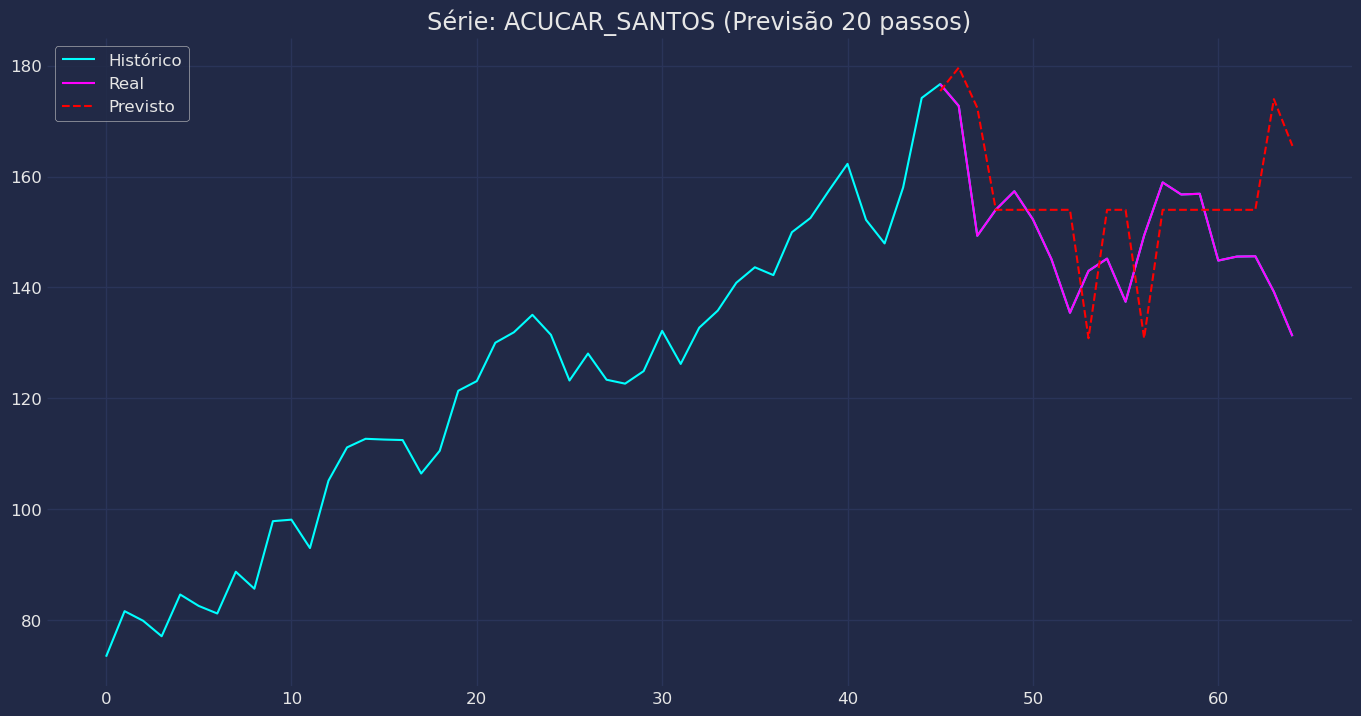


=== Série: ACUCAR_SP ===

=== Série: ACUCAR_SP (horizon=80) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(

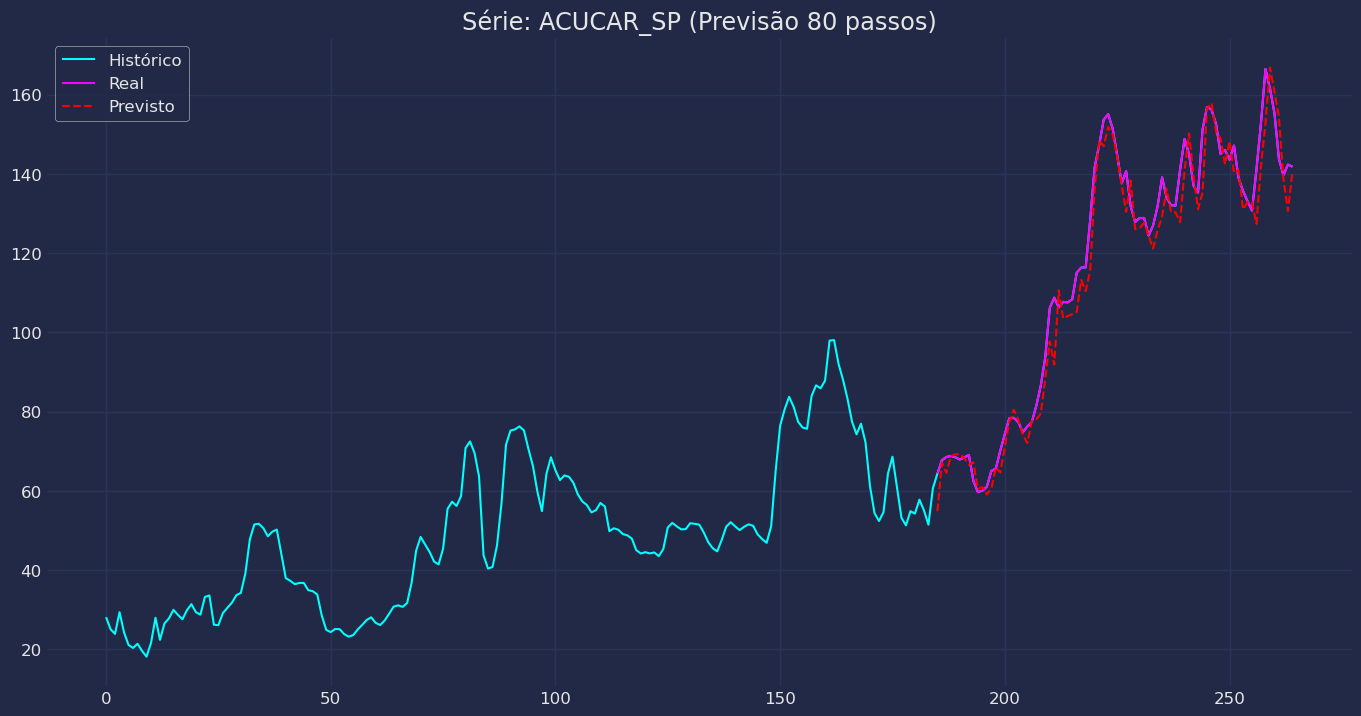


=== Série: ALGODAO ===

=== Série: ALGODAO (horizon=105) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=

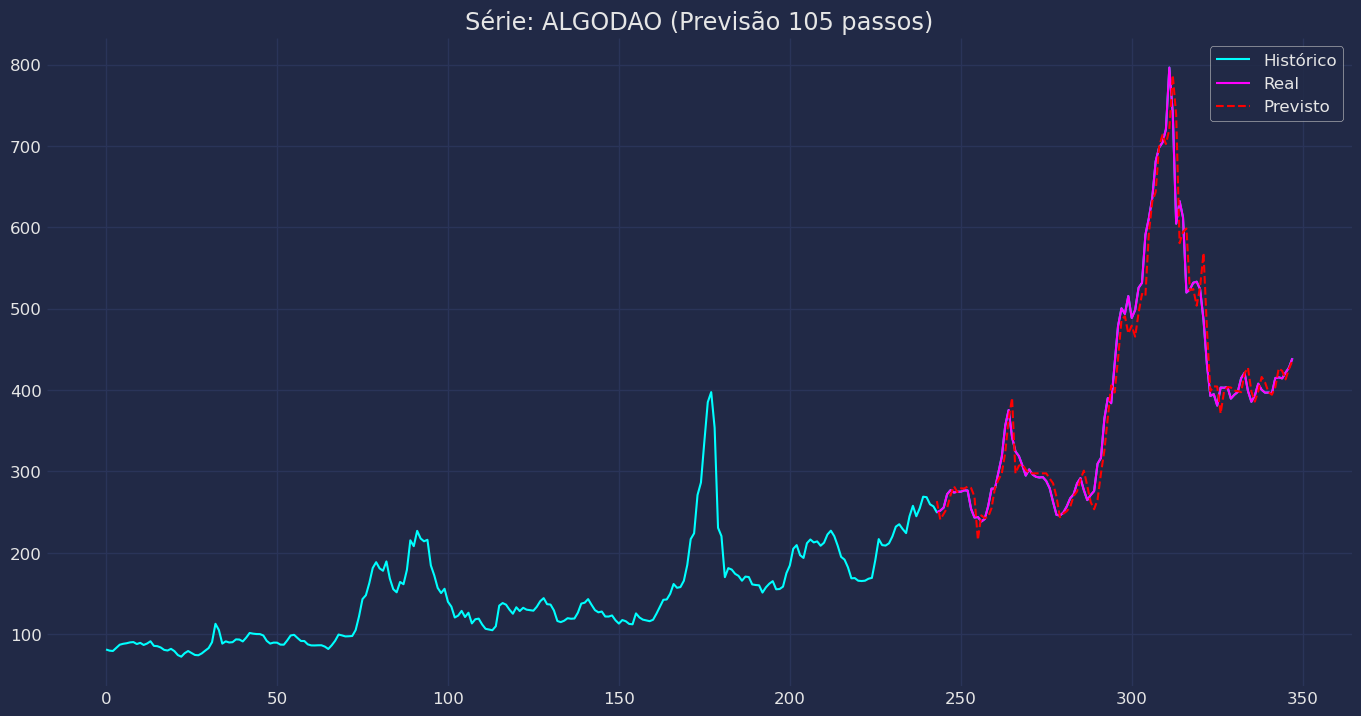


=== Série: ARROZ ===

=== Série: ARROZ (horizon=72) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

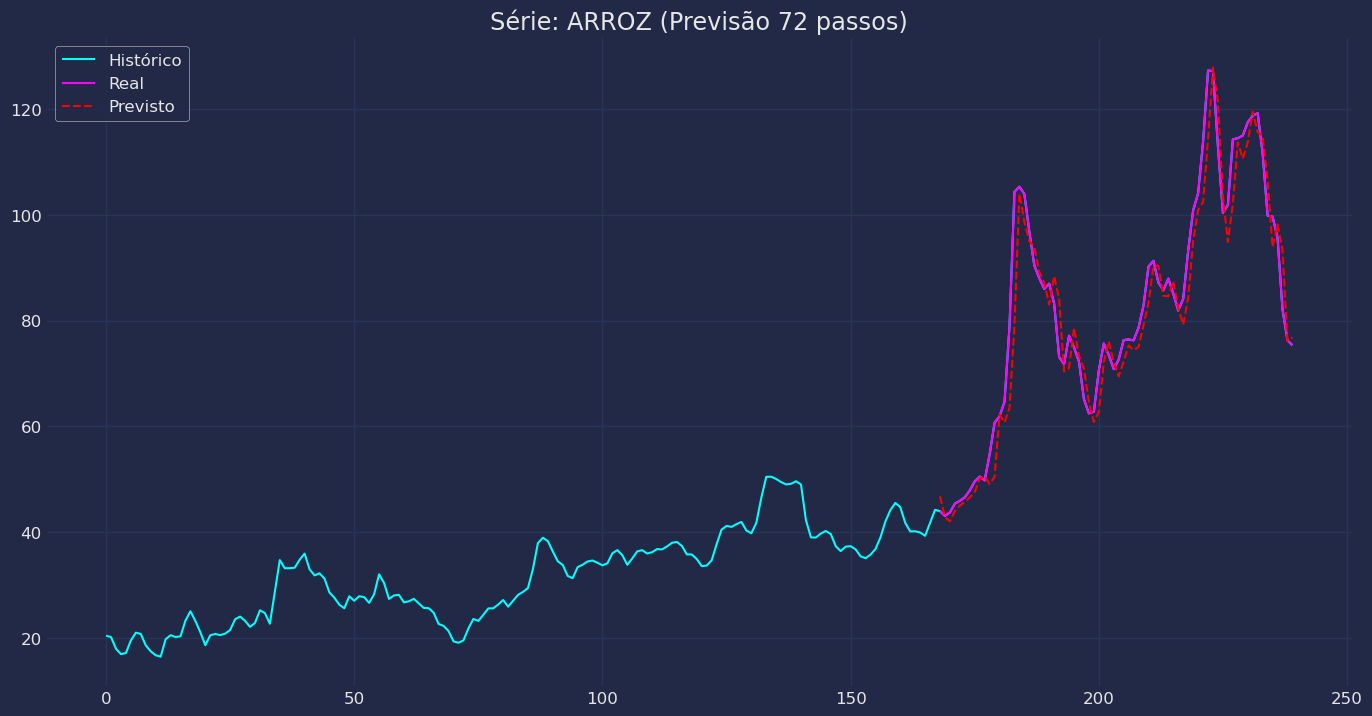


=== Série: CAFE_ARABICA ===

=== Série: CAFE_ARABICA (horizon=104) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categori

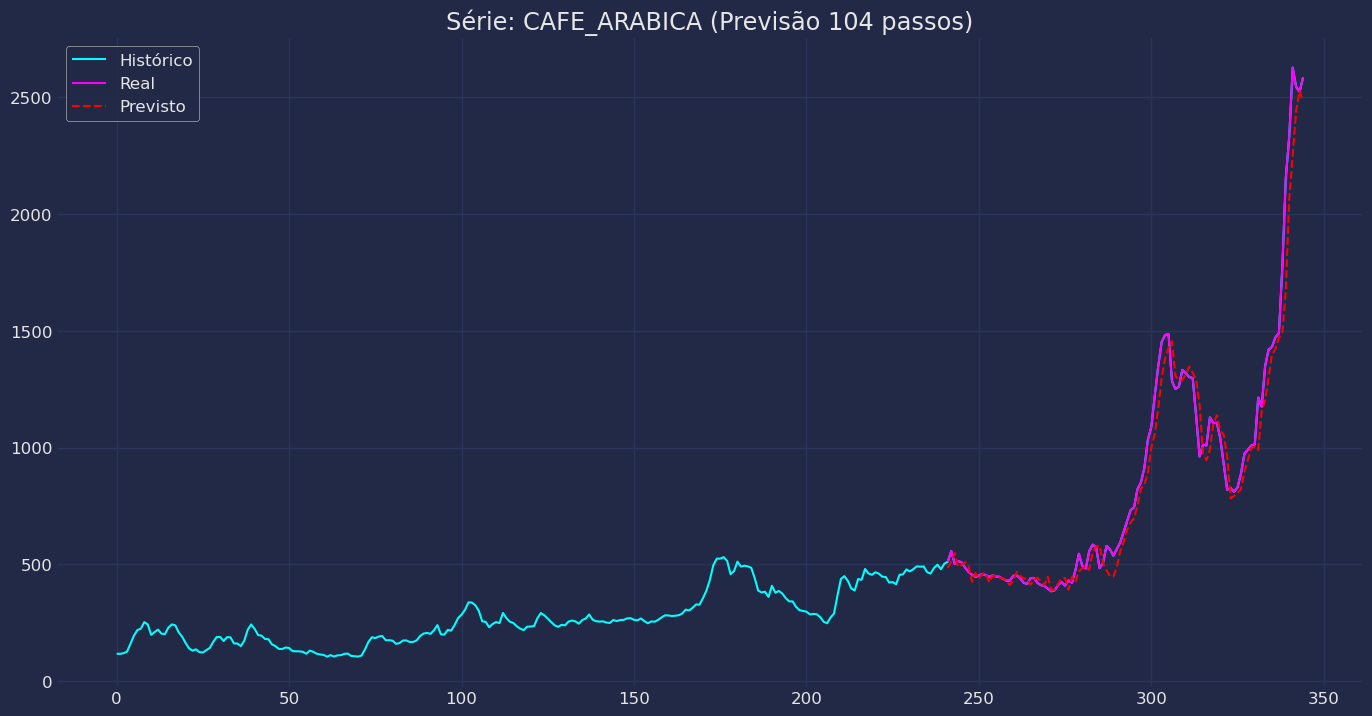


=== Série: CAFE_ROBUSTA ===

=== Série: CAFE_ROBUSTA (horizon=87) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
RandomFores

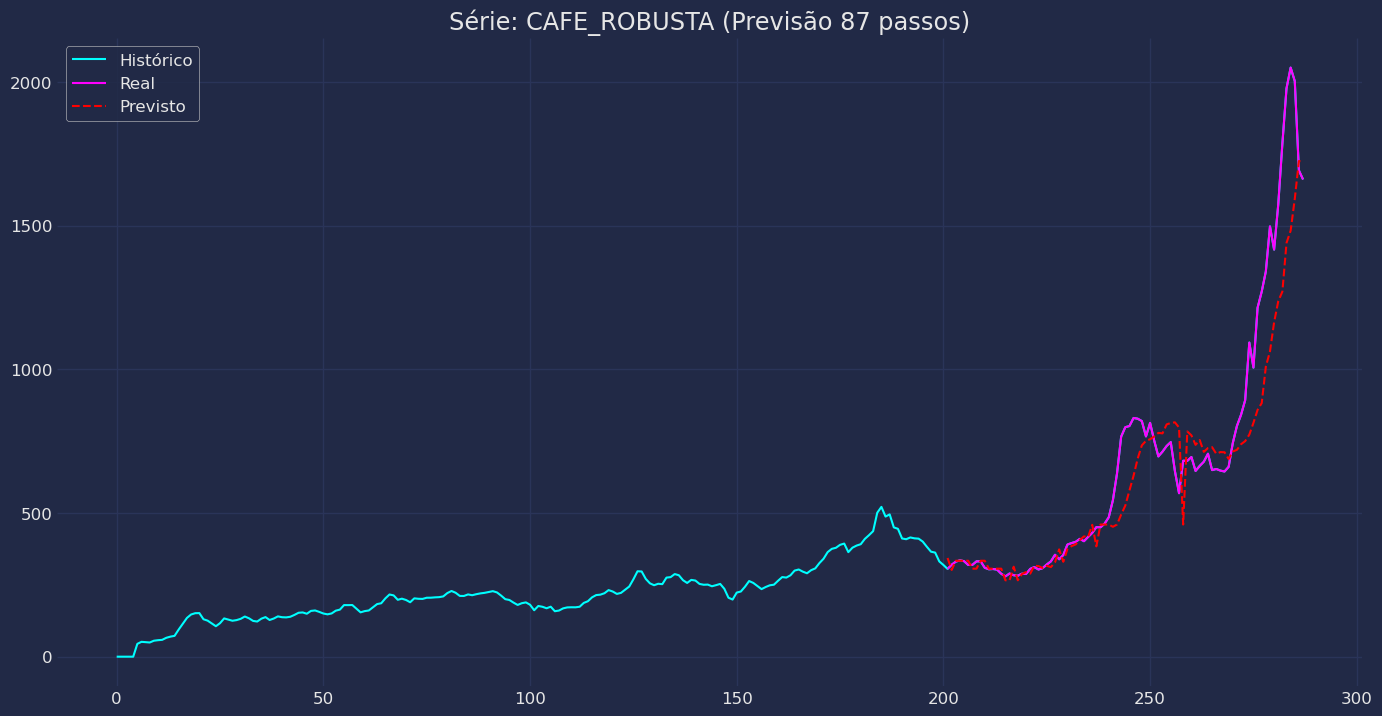


=== Série: MILHO ===

=== Série: MILHO (horizon=75) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable

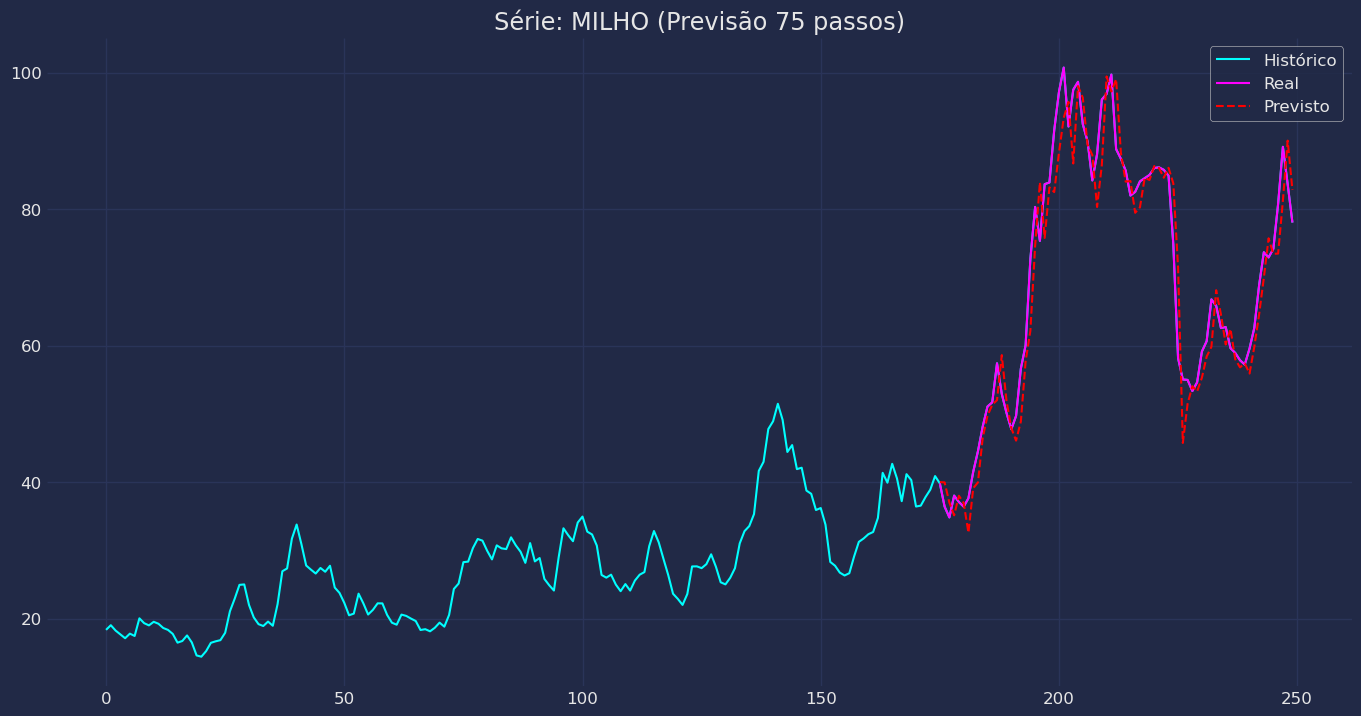


=== Série: SOJA_PARANA ===

=== Série: SOJA_PARANA (horizon=101) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
MLPRegressor

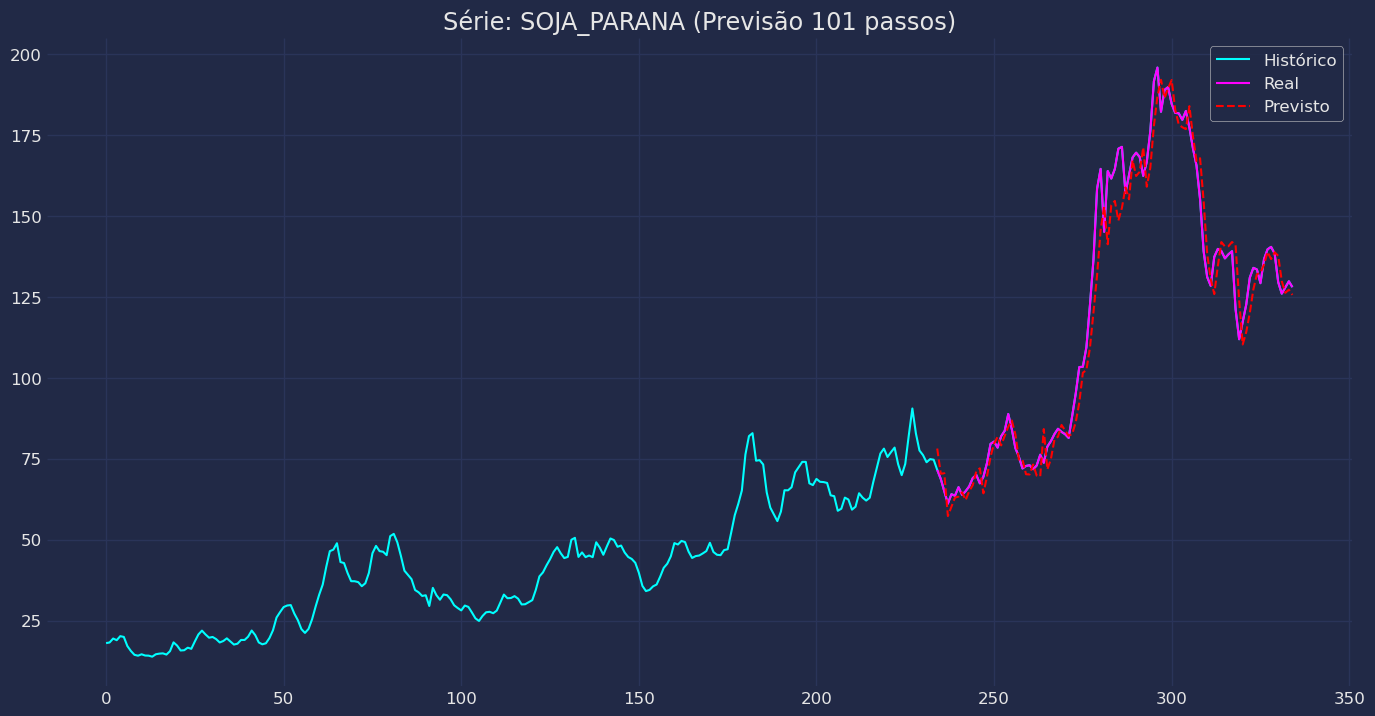


=== Série: SOJA_PARANAGUA ===

=== Série: SOJA_PARANAGUA (horizon=70) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500

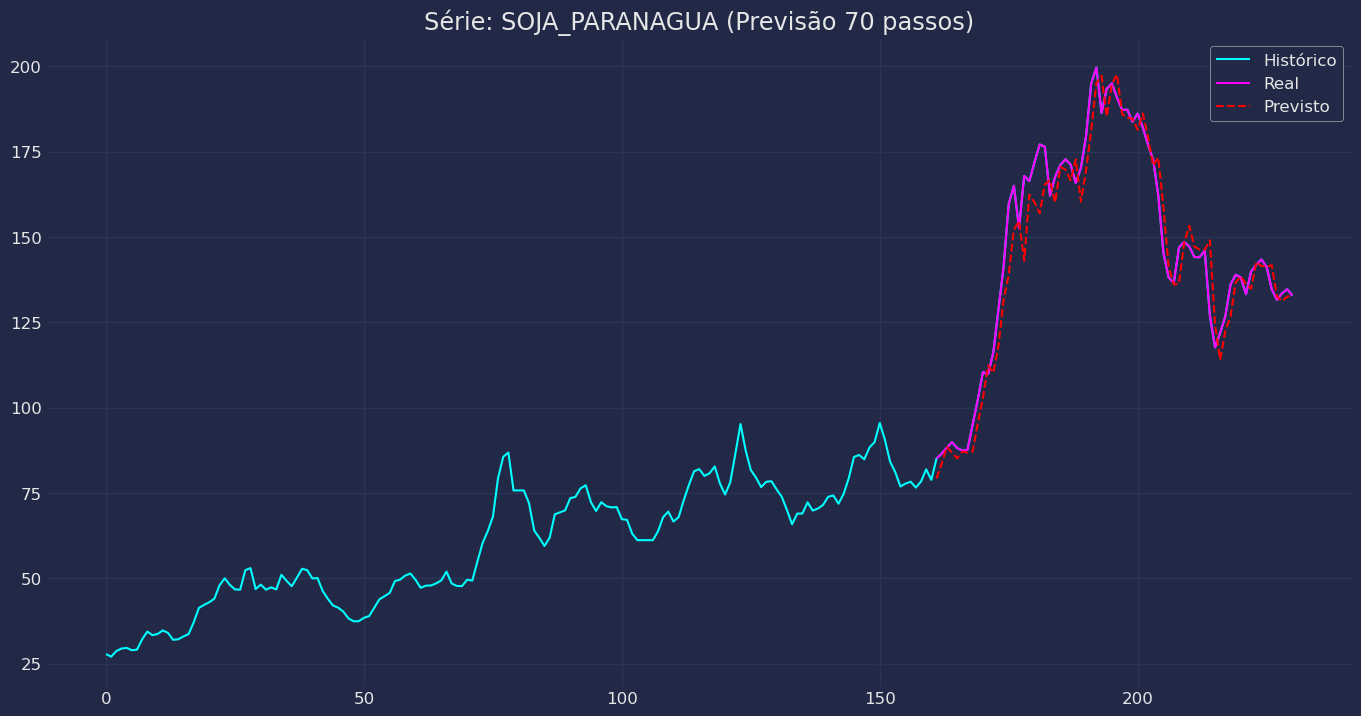


=== Série: TRIGO_PARANA ===

=== Série: TRIGO_PARANA (horizon=77) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=

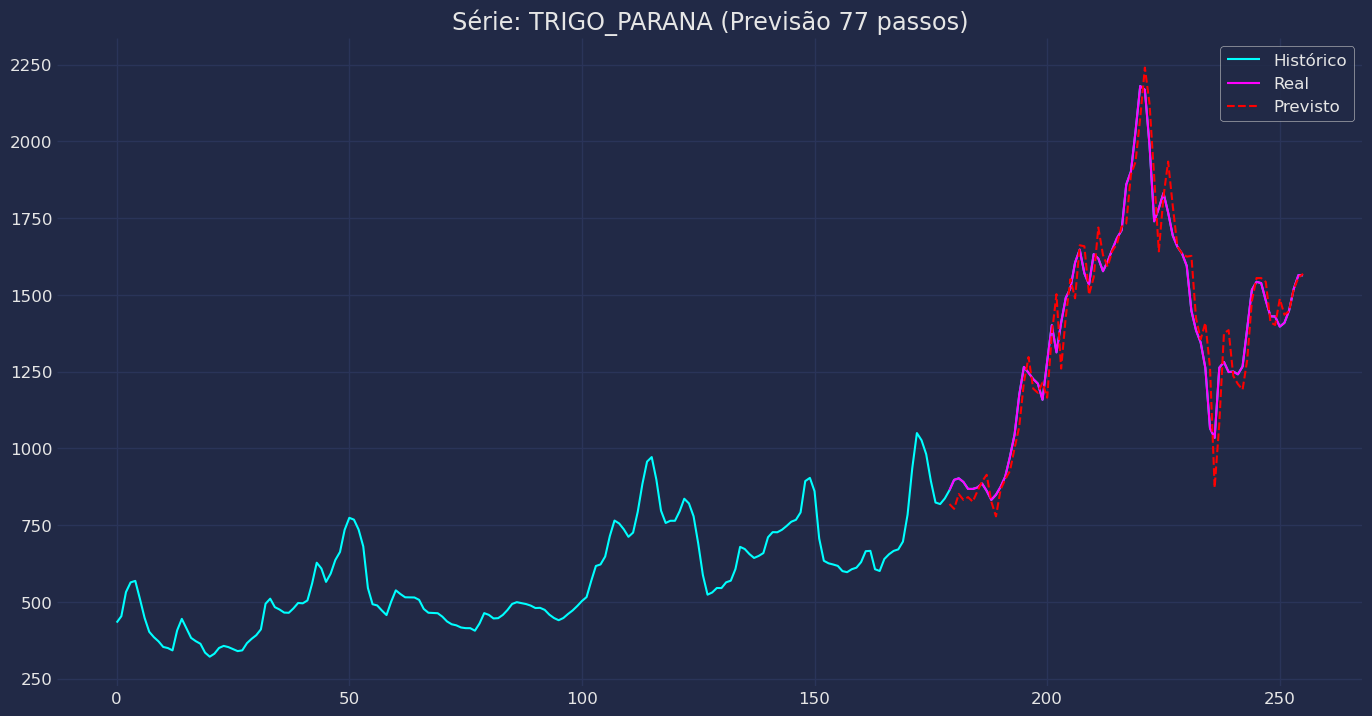


=== Série: TRIGO_RS ===

=== Série: TRIGO_RS (horizon=77) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, re

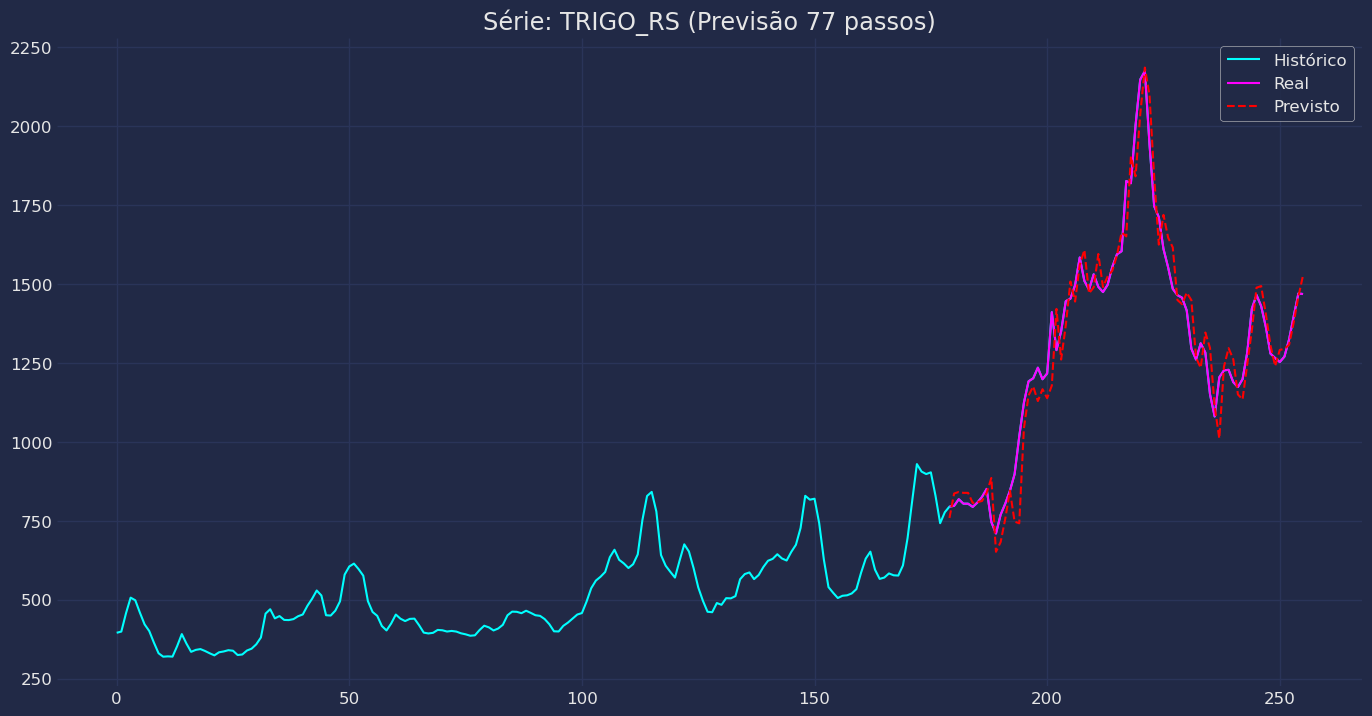


Resumo das métricas:
         unique_id           mse        rmse         mae      mape
0    ACUCAR_SANTOS    225.596605   15.019874   11.273021  0.078986
1        ACUCAR_SP     36.955341    6.079090    4.527195  0.038876
2          ALGODAO    769.381131   27.737720   18.286649  0.045276
3            ARROZ     35.989279    5.999107    4.239831  0.050131
4     CAFE_ARABICA  10215.663493  101.072565   63.058198  0.065961
5     CAFE_ROBUSTA  28841.659661  169.828324  101.664923  0.112002
6            MILHO     25.026966    5.002696    3.839577  0.056078
7      SOJA_PARANA     64.203450    8.012706    5.927454  0.048997
8   SOJA_PARANAGUA     64.393454    8.024553    5.866010  0.040019
9     TRIGO_PARANA   6837.263916   82.687749   62.718361  0.046806
10        TRIGO_RS   7405.750333   86.056669   65.440947  0.051803


In [57]:
dcs = DCSLARegressor(models, top_k=1, similarity='euclidean')

results = []

for uid in df_brl['unique_id'].unique():
    print(f"\n=== Série: {uid} ===")

    horizon = series_test_sizes.get(uid)
    print(f"\n=== Série: {uid} (horizon={horizon}) ===")
    y_series = df_brl[df_brl['unique_id'] == uid]['y'].values

    y_train = y_series[:-horizon]
    windows, targets = dcs._extract_lag_windows(y_train)
    dcs.fit(windows, targets)

    forecast, y_real_future = dcs.predict(y_series, horizon=horizon)

    mse = mean_squared_error(y_real_future, forecast)
    rmse = root_mean_squared_error(y_real_future, forecast)
    mae = mean_absolute_error(y_real_future, forecast)
    mape = mean_absolute_percentage_error(y_real_future, forecast)

    results.append({
        "unique_id": uid,
        "horizon": horizon,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "y_real_future": y_real_future,
        "forecast": forecast
    })

    print("Valores reais:    ", np.round(y_real_future, 2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

    # plotar série inteira
    plt.figure(figsize=(15, 8))
    plt.plot(y_series, label="Histórico", color="cyan")
    plt.plot(range(len(y_series)-horizon, len(y_series)), y_real_future, label="Real", color="fuchsia")
    plt.plot(range(len(y_series)-horizon, len(y_series)), forecast, label="Previsto", color="red", linestyle="--")
    plt.title(f"Série: {uid} (Previsão {horizon} passos)")
    plt.legend()
    plt.show()

# Converter resultados em DataFrame para análise geral
df_results = pd.DataFrame(results)
print("\nResumo das métricas:")
print(df_results[["unique_id", "mse", "rmse", "mae", "mape"]])

In [8]:
for model in dcs.history_errors:
    print("############### Model ###############")
    print(model)
    print("Error history:")
    print(dcs.history_errors.get(model))
    print("Times used:")
    print(len(dcs.history_errors.get(model)))

############### Model ###############
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
Error history:
[23.080579603521585, 9.505139644232266, 4.01999635370413, 2.3482140081463285, 1.940466148278631, 0.8778111809427145, 4.801675898032087, 10.220879713298686, 16.91895329268874, 13.85459354156967, 7.678510481644082, 25.76654510125792, 22.051956326266662, 10.685509035002326, 22.3475209114753, 44.36513293289255, 2.7959098668729823, 0.90381477470725, 2.0306746433873286, 10.285446827840097, 26.038870641780818, 28.303675054034898, 23.187089084175682, 14.75852774572786, 20.817131982258502, 16.707020684742304, 51.68792919327859, 15.97627132026139, 75.23242571525844, 103.63110691879046, 37.949094651910514, 29.661480774340134, 1.2228997873141338, 6.545927595942828, 16.601392620649335, 1.1044051499994225, 34.428080705951345, 15.823731121547894, 10.61450332798097, 8.87890069238477


=== Série: ACUCAR_SANTOS ===

=== Série: ACUCAR_SANTOS (horizon=20) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
         

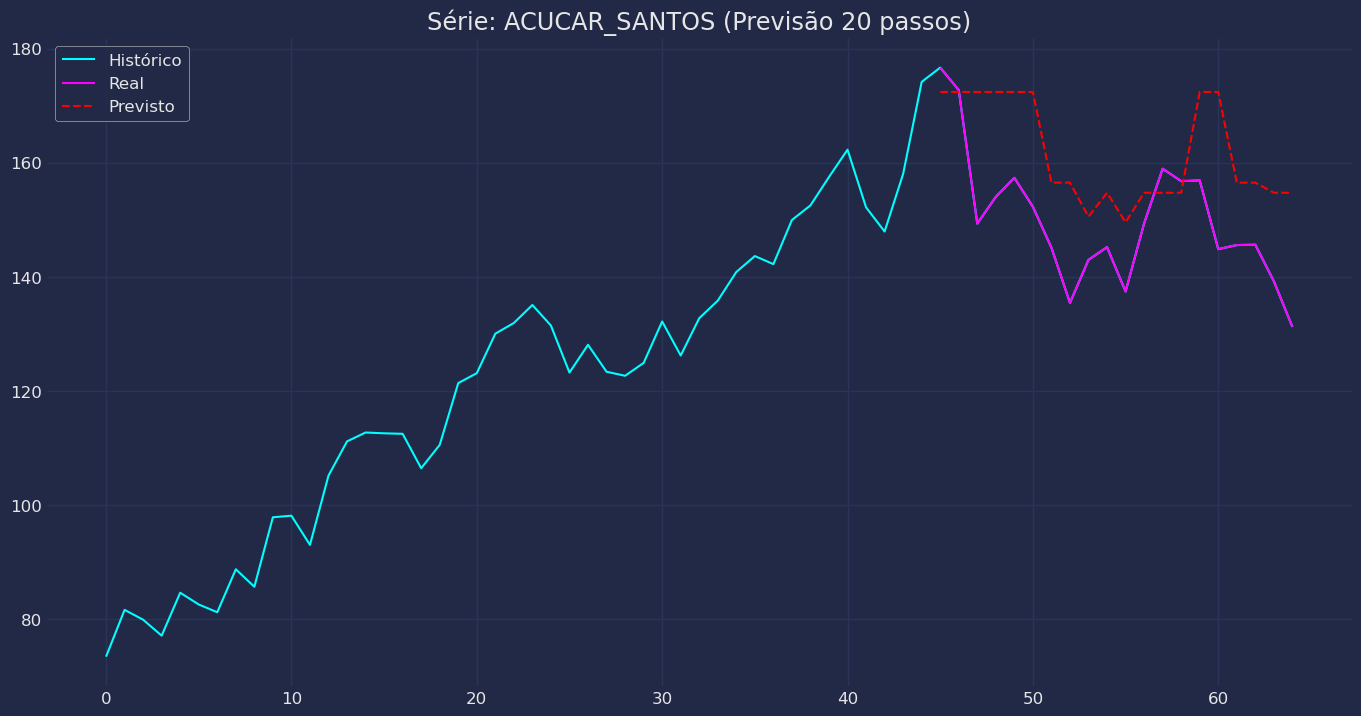


=== Série: ACUCAR_SP ===

=== Série: ACUCAR_SP (horizon=80) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num

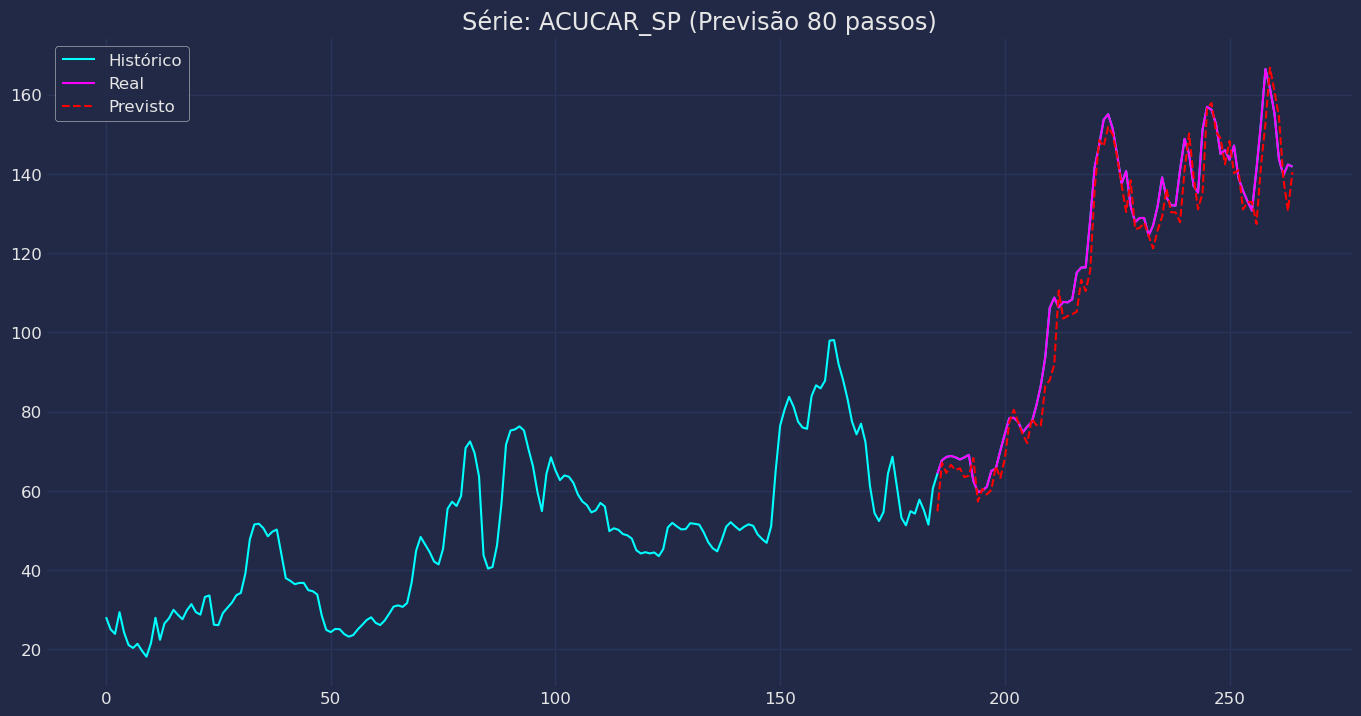


=== Série: ALGODAO ===

=== Série: ALGODAO (horizon=105) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_le

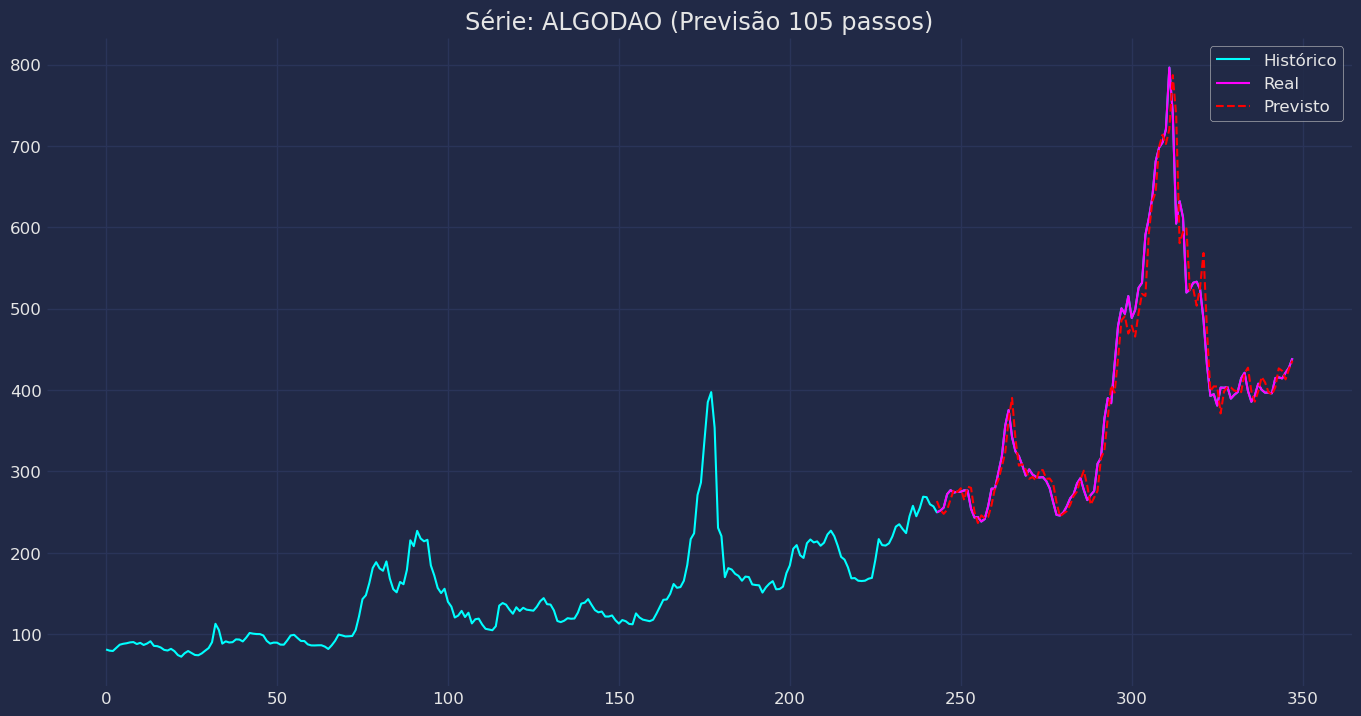


=== Série: ARROZ ===

=== Série: ARROZ (horizon=72) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
MLPRegressor(hidden_

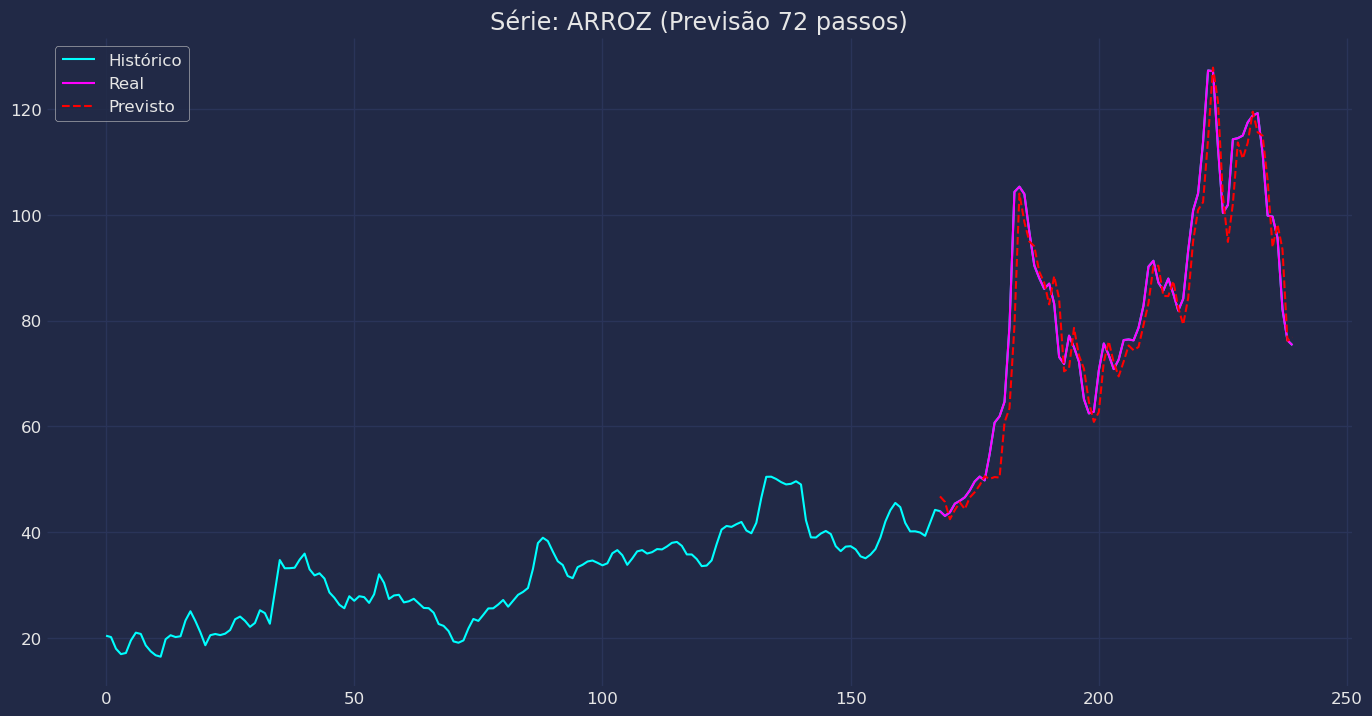


=== Série: CAFE_ARABICA ===

=== Série: CAFE_ARABICA (horizon=104) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
          

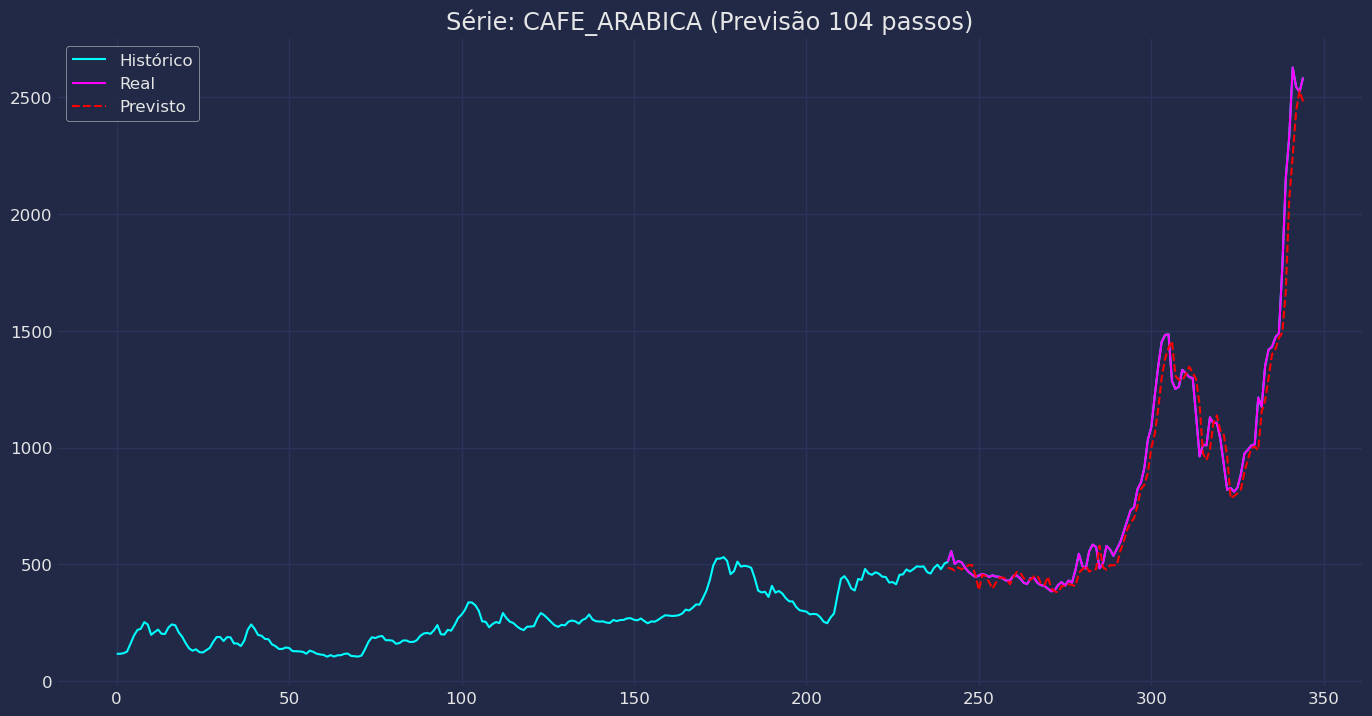


=== Série: CAFE_ROBUSTA ===

=== Série: CAFE_ROBUSTA (horizon=87) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomFo

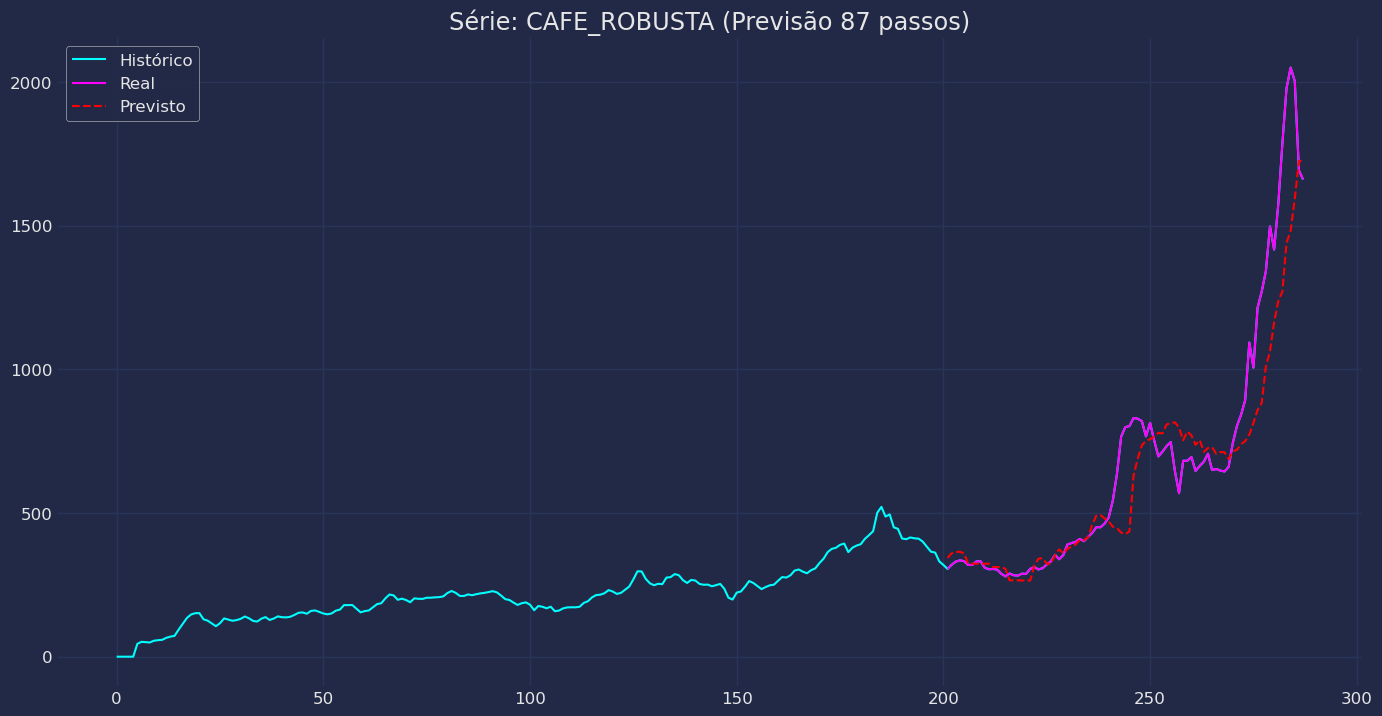


=== Série: MILHO ===

=== Série: MILHO (horizon=75) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=

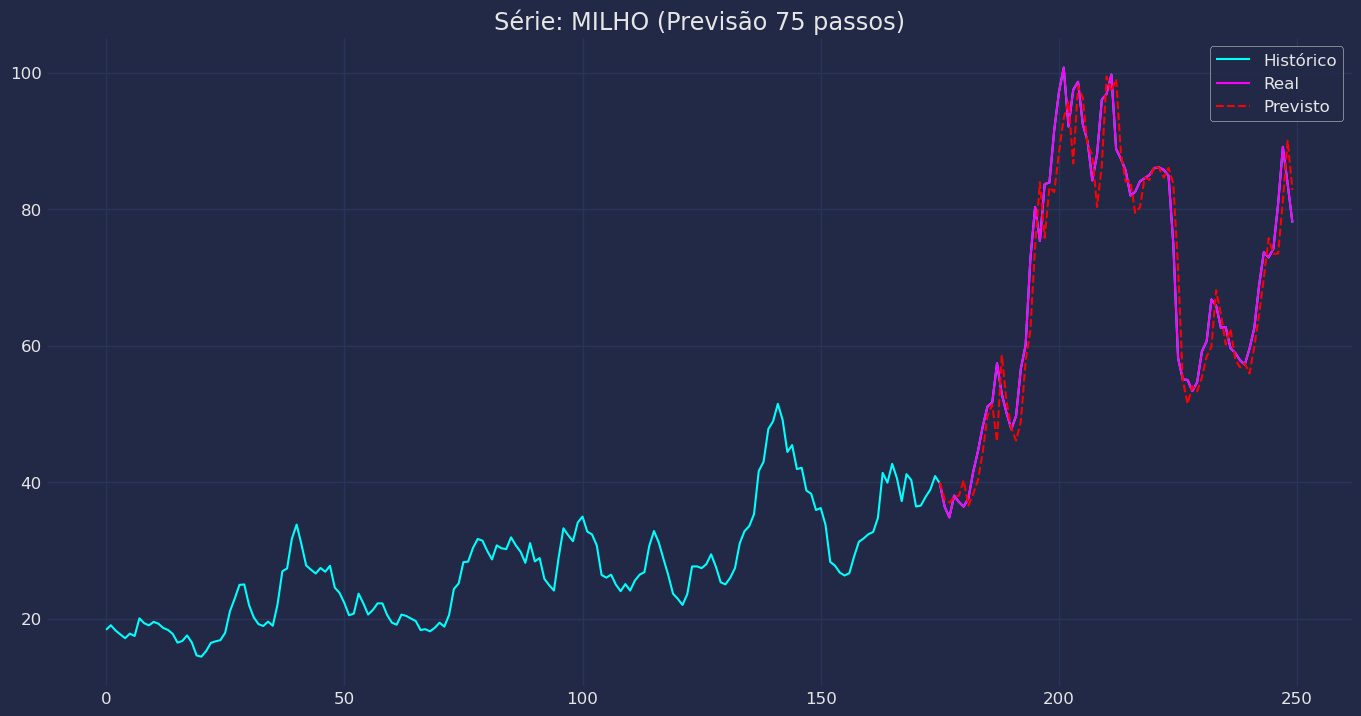


=== Série: SOJA_PARANA ===

=== Série: SOJA_PARANA (horizon=101) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegre

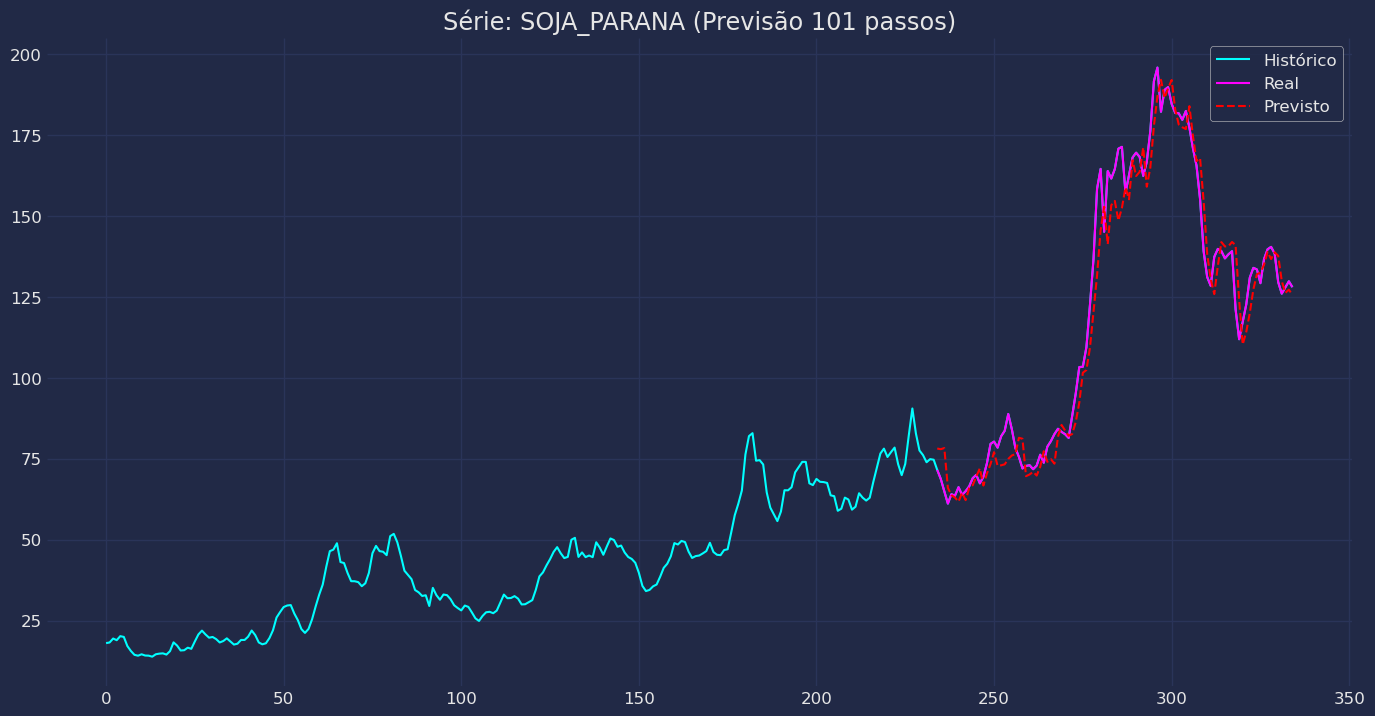


=== Série: SOJA_PARANAGUA ===

=== Série: SOJA_PARANAGUA (horizon=70) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
       

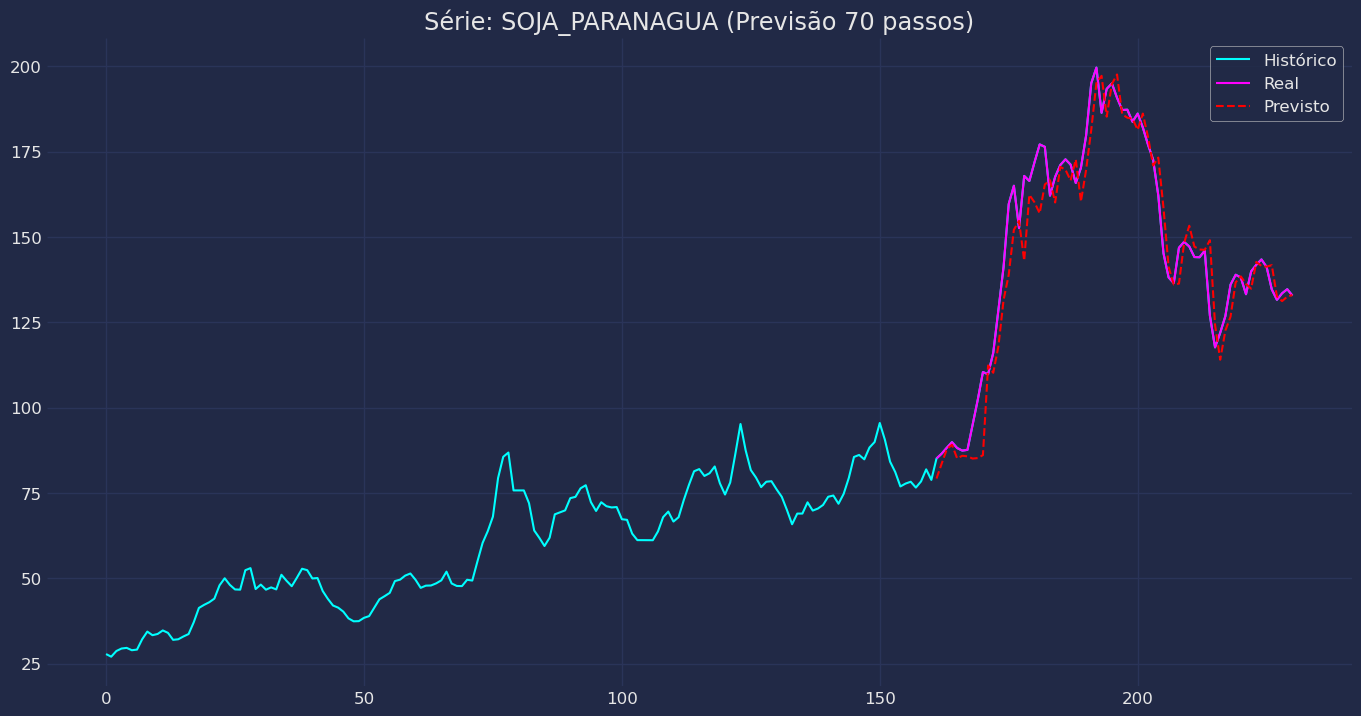


=== Série: TRIGO_PARANA ===

=== Série: TRIGO_PARANA (horizon=77) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
           

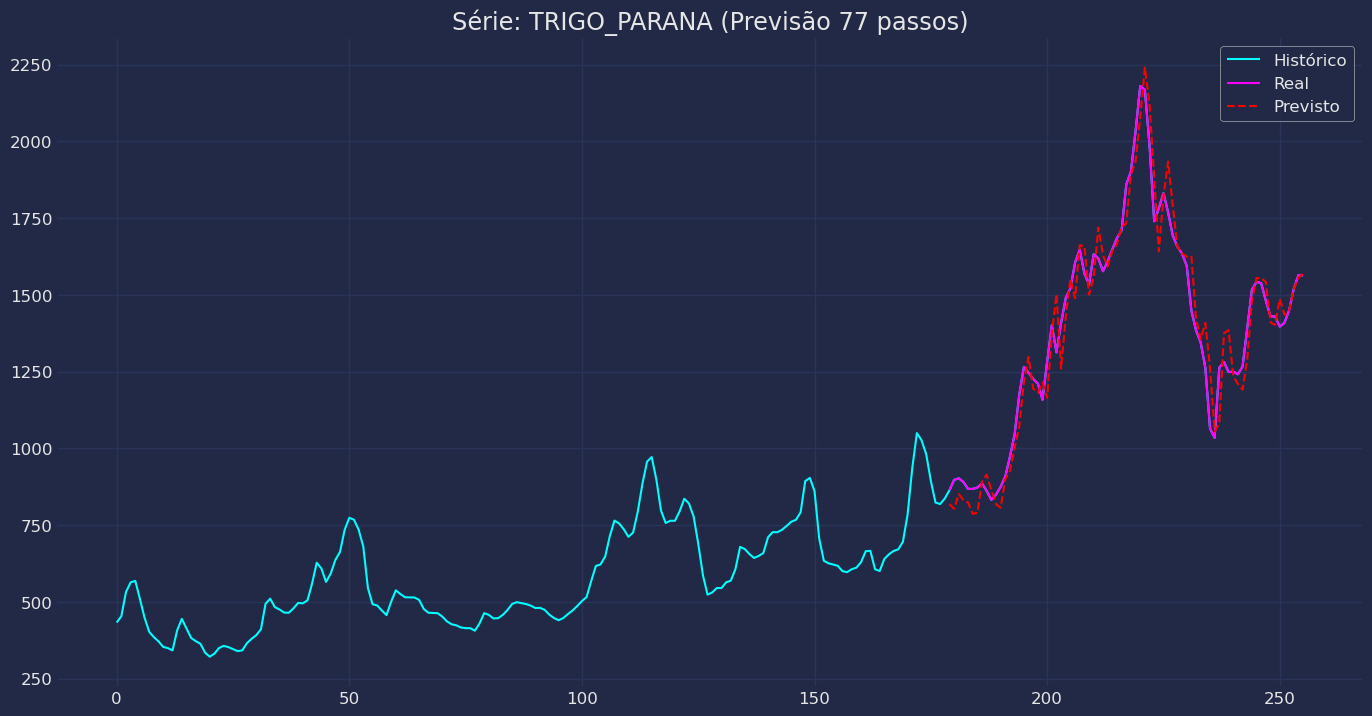


=== Série: TRIGO_RS ===

=== Série: TRIGO_RS (horizon=77) ===
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_l

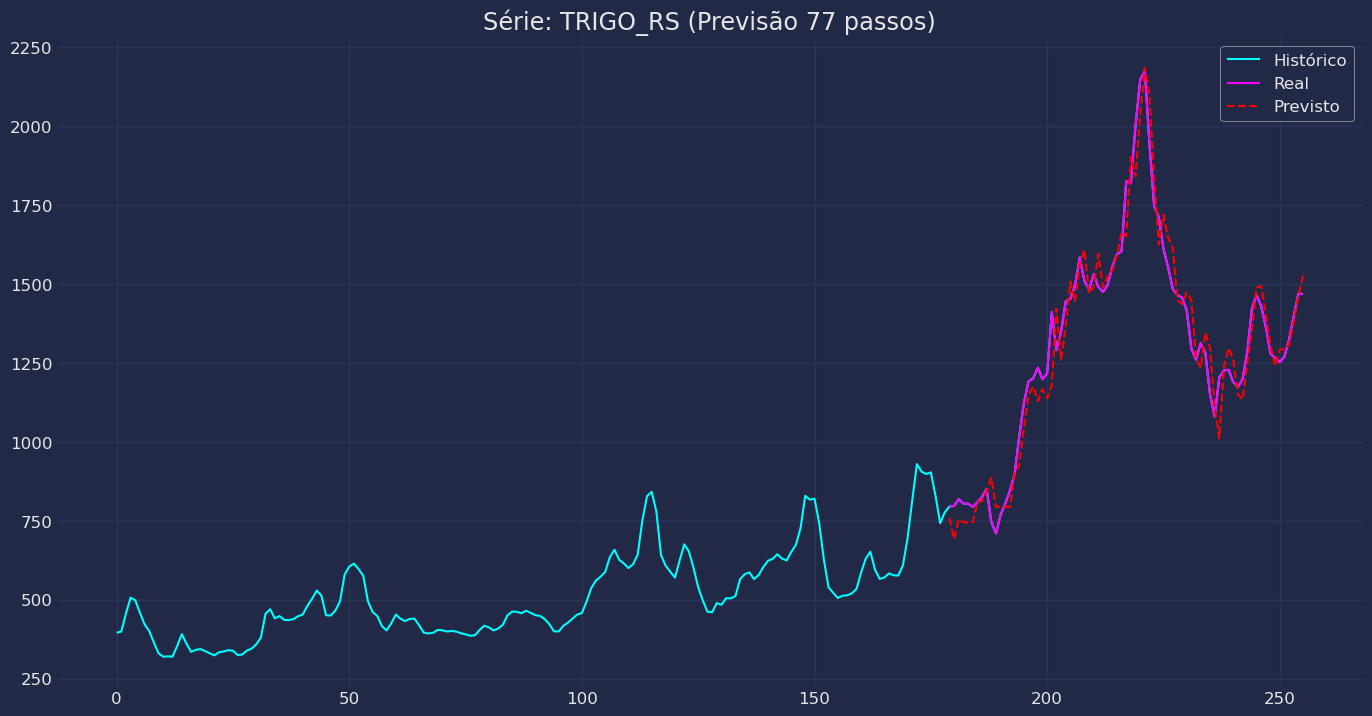


Resumo das métricas:
         unique_id           mse        rmse         mae      mape
0    ACUCAR_SANTOS    223.567005   14.952157   12.922137  0.088678
1        ACUCAR_SP     42.926396    6.551824    4.980362  0.044610
2          ALGODAO    732.401714   27.062921   17.322651  0.041728
3            ARROZ     37.872291    6.154047    4.435594  0.053563
4     CAFE_ARABICA  10377.052605  101.867819   65.099969  0.069841
5     CAFE_ROBUSTA  30588.313681  174.895151  105.469632  0.120433
6            MILHO     25.030504    5.003049    3.756506  0.053997
7      SOJA_PARANA     71.127374    8.433705    6.435300  0.055376
8   SOJA_PARANAGUA     75.977237    8.716492    6.282362  0.043954
9     TRIGO_PARANA   6686.581447   81.771520   63.138018  0.047621
10        TRIGO_RS   6460.530219   80.377424   63.262079  0.049949


In [9]:
dcs = DCSLARegressor(models_top_k_10, top_k=10, similarity='euclidean')

results = []

for uid in df_brl['unique_id'].unique():
    print(f"\n=== Série: {uid} ===")

    horizon = series_test_sizes.get(uid)
    print(f"\n=== Série: {uid} (horizon={horizon}) ===")
    y_series = df_brl[df_brl['unique_id'] == uid]['y'].values

    y_train = y_series[:-horizon]
    windows, targets = dcs._extract_lag_windows(y_train)
    dcs.fit(windows, targets)

    forecast, y_real_future = dcs.predict(y_series, horizon=horizon)

    mse = mean_squared_error(y_real_future, forecast)
    rmse = root_mean_squared_error(y_real_future, forecast)
    mae = mean_absolute_error(y_real_future, forecast)
    mape = mean_absolute_percentage_error(y_real_future, forecast)

    results.append({
        "unique_id": uid,
        "horizon": horizon,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "y_real_future": y_real_future,
        "forecast": forecast
    })

    print("Valores reais:    ", np.round(y_real_future, 2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

    # plotar série inteira
    plt.figure(figsize=(15, 8))
    plt.plot(y_series, label="Histórico", color="cyan")
    plt.plot(range(len(y_series)-horizon, len(y_series)), y_real_future, label="Real", color="fuchsia")
    plt.plot(range(len(y_series)-horizon, len(y_series)), forecast, label="Previsto", color="red", linestyle="--")
    plt.title(f"Série: {uid} (Previsão {horizon} passos)")
    plt.legend()
    plt.show()

# Converter resultados em DataFrame para análise geral
df_results = pd.DataFrame(results)
print("\nResumo das métricas:")
print(df_results[["unique_id", "mse", "rmse", "mae", "mape"]])

In [10]:
for model in dcs.history_errors:
    print("############### Model ###############")
    print(model)
    print("Error history:")
    print(dcs.history_errors.get(model))
    print("Times used:")
    print(len(dcs.history_errors.get(model)))

############### Model ###############
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
Error history:
[4.270197338834322, 0.32407829121527243, 23.080579603521585, 18.377876254239283, 15.050053287732112, 20.12292170878473, 15.507948024574205, 27.55333079969384, 9.505139644232266, 0.5872952707748738, 4.01999635370413, 2.2559448464331666, 3.2065367460094762, 2.2103920646198816, 4.999166129450721, 5.225425309898597, 2.3482140081463285, 0.4659470662480203, 1.940466148278631, 4.776114110802041, 0.5776813448611335, 6.921072423408837, 6.25743540525194, 0.8778111809427145, 4.801675898032087, 10.220879713298686, 7.27319111934824, 18.23992664851353, 16.91895329268874, 13.85459354156967, 1.1207659814131148, 7.678510481644082, 19.183497426983877, 11.299399352607281, 3.625412874986239, 0.40108326046686216, 4.223327486324649, 11.996604236192695, 11.924248268503902, 2.79590986687298

- LSTM do Keras
- Verificar a formação das janelas
- Normalização da série no começo com MinMaxScaler
- Fine tunning da literatura
- Adicioanar ARIMA e ETS no pool
- Extra: Pool SVRs